In [1]:
!pip install xgboost -q

import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/winequalityN.csv')

print(df.head())

In [4]:
df['Vinho_bom'] = (df['quality'] >= 6).astype(int)

print(df['Vinho_bom'].value_counts(normalize=True))

Vinho_bom
1    0.633061
0    0.366939
Name: proportion, dtype: float64


In [7]:
X = df.drop(columns=['quality', 'Vinho_bom', 'type'])

y = df['Vinho_bom']
X_treino, X_teste, y_treino, y_teste = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [8]:
modelo = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

modelo.fit(X_treino, y_treino)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:38:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.74      0.70      0.72       477
           1       0.83      0.86      0.85       823

    accuracy                           0.80      1300
   macro avg       0.79      0.78      0.78      1300
weighted avg       0.80      0.80      0.80      1300

Acurácia: 0.802


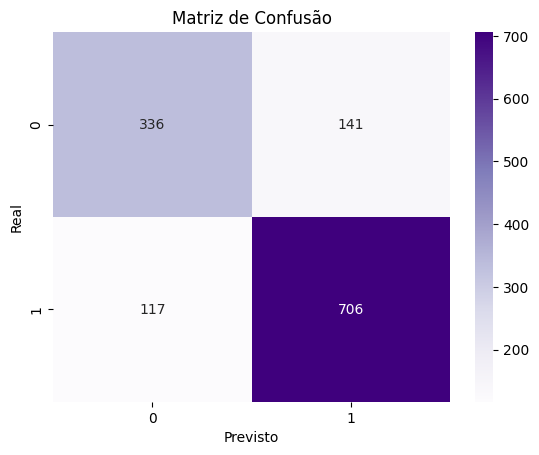

In [9]:
y_predito = modelo.predict(X_teste)

print("Relatório de Classificação:\n", classification_report(y_teste, y_predito))
print(f"Acurácia: {accuracy_score(y_teste, y_predito):.3f}")

matriz = confusion_matrix(y_teste, y_predito)
sns.heatmap(matriz, annot=True, fmt='d', cmap='Purples')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()
